### DBSCAN explores complete dataset with ep=0.2 (the neighbour taxi radius is set to 0.2 units). Due to RAM overflow, the dataset sample is reduced to 50000 and eps reduced to 0.008 units.
### Resultant output with the number of cluster is plotted in the map and scatter plot.

In [1]:
!pip install scikit-learn


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

In [4]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [5]:
import sklearn
print(sklearn.__version__)

1.7.0


✅ Step 2: Filter the DataFrame to only keep valid rows

In [6]:
import pandas as pd
lat_range = (18.15, 53.55)
lon_range = (73.50, 134.77)

# Load data
df = pd.read_csv("D:/Research/Papers/repo/IEEE_SubResizeUsingAIForFleetVehicles/data/taxi_data_merged.csv")
df_cleaned = df[
    df['latitude'].between(*lat_range) &
    df['longitude'].between(*lon_range)
]

print(f"Original GPS points: {len(df)}")
print(f"Cleaned GPS points: {len(df_cleaned)}")
print(f"Removed outliers: {len(df) - len(df_cleaned)}")

Original GPS points: 1027004
Cleaned GPS points: 1026539
Removed outliers: 465


Run a spatio-temporal DBSCAN, where time is considered as a third dimension:

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Convert timestamp to numeric (e.g., seconds since epoch)
df_cleaned['ts_num'] = pd.to_datetime(df_cleaned['timestamp']).astype(np.int64) // 10**9
df_cleaned.head(3)

C:\Users\uif74417\AppData\Local\Temp\ipykernel_41368\571143057.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['ts_num'] = pd.to_datetime(df_cleaned['timestamp']).astype(np.int64) // 10**9


,taxiid,timestamp,longitude,latitude,ts_num
0,6211,2008-02-02 13:30:49,116.35278,39.98036,1201959049
1,6211,2008-02-02 13:30:54,116.35279,39.98036,1201959054
2,6211,2008-02-02 13:30:59,116.35279,39.98037,1201959059


run a spatio-temporal DBSCAN, where time is considered as a third dimension

In [10]:
# Combine lat, lon, and time into one feature space
features = df_cleaned[['latitude', 'longitude', 'ts_num']]
features_scaled = MinMaxScaler().fit_transform(features)

db = DBSCAN(eps=0.05, min_samples=10).fit(features_scaled)
df_cleaned['cluster'] = db.labels_
df_cleaned.head(3)

MemoryError: 

#### DBSCAN has O(n²) complexity because it compares every point to every other.
#### You’re likely using millions of GPS records.
#### This causes it to exceed available RAM.

In [23]:
# Option 1: Use a sample of the data
# For exploration, try running DBSCAN on a smaller subset:
df_sample = df_cleaned.sample(n=50000, random_state=42)  # adjust as needed
features = df_sample[['latitude', 'longitude', 'ts_num']]
features_scaled = MinMaxScaler().fit_transform(features)

db = DBSCAN(eps=0.01, min_samples=10).fit(features_scaled)
df_sample['cluster'] = db.labels_
df_sample.head(3)

,taxiid,timestamp,longitude,latitude,ts_num,cluster
791689,409,2008-02-03 08:38:40,116.51141,40.00652,1202027920,0
484632,6275,2008-02-03 18:42:48,116.49524,39.97051,1202064168,0
74174,5352,2008-02-03 20:21:59,116.13620,39.73459,1202070119,0


visualize and analyze spatio-temporal clusters and outliers after applying DBSCAN on sample data
✅ Step 1: Check cluster label distribution

In [24]:
# Count how many points in each cluster
cluster_counts = df_sample['cluster'].value_counts().sort_index()
print(cluster_counts)

# Exclude outlier label (-1)
valid_clusters = df_sample['cluster'].value_counts().sort_index()
valid_clusters = valid_clusters[valid_clusters.index != -1]

print("Valid Clusters (excluding outliers):")
print(valid_clusters)

#Optional: Count only number of valid clusters
num_valid_clusters = (df_sample['cluster'].nunique()) - (1 if -1 in df_sample['cluster'].unique() else 0)
print(f"Number of valid clusters: {num_valid_clusters}")

cluster
-1      300
 0    49671
 1       17
 2       12
Name: count, dtype: int64
Valid Clusters (excluding outliers):
cluster
0    49671
1       17
2       12
Name: count, dtype: int64
Number of valid clusters: 3


# What does above output mean
Your main dataset is extremely dense in one core area (cluster 0).
Clusters 1 and 2 are very small and possibly borderline noise.
Outliers (300) are now being detected — that's a good sign.
You're seeing DBSCAN's density sensitivity in action — as eps shrinks, minor separations start forming.

✅ What You Can Do Next
1. Inspect Small Clusters. To see what those 17 and 12-point clusters are:

In [25]:
small_clusters = df_sample[df_sample['cluster'].isin([1, 2])]
print(small_clusters[['taxiid', 'timestamp', 'latitude', 'longitude']])

        taxiid            timestamp  latitude  longitude
957150    5075  2008-02-05 19:27:16  40.44460  115.96712
858706    2465  2008-02-05 18:45:31  40.48264  115.93205
858686    2465  2008-02-05 16:50:31  40.48263  115.93203
190568    3872  2008-02-05 11:07:54  40.54218  116.81632
190665    3872  2008-02-05 11:22:43  40.59515  116.82970
957018    5075  2008-02-05 18:15:56  40.43892  115.98147
190570    3872  2008-02-05 11:08:51  40.54825  116.81412
956964    5075  2008-02-05 17:50:06  40.39636  115.90853
956958    5075  2008-02-05 17:49:36  40.39199  115.90458
957084    5075  2008-02-05 18:36:36  40.44459  115.96713
956949    5075  2008-02-05 17:48:46  40.38281  115.90464
957114    5075  2008-02-05 19:14:21  40.44466  115.96713
858681    2465  2008-02-05 16:30:31  40.48261  115.93202
190497    3872  2008-02-05 10:39:11  40.36663  116.82030
190638    3872  2008-02-05 11:19:10  40.57792  116.82983
190594    3872  2008-02-05 11:12:55  40.56275  116.79870
190732    3872  2008-02-05 11:3

visualize using plot

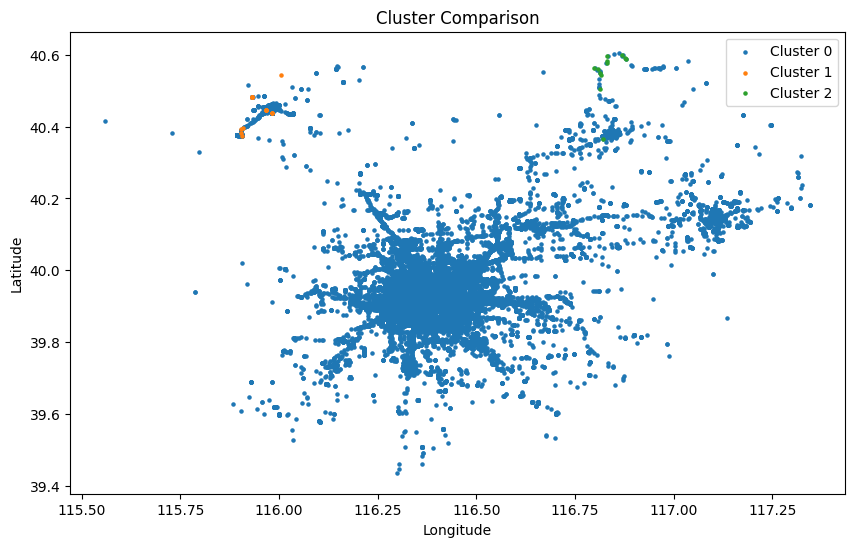

In [26]:
import matplotlib.pyplot as plt
# Visualize the clusters
plt.figure(figsize=(10, 6))
for label in [0, 1, 2]:
    cluster_points = df_sample[df_sample['cluster'] == label]
    plt.scatter(cluster_points['longitude'], cluster_points['latitude'], s=5, label=f"Cluster {label}")
plt.legend()
plt.title("Cluster Comparison")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Try smaller eps to see massive cluster 0 into smaller clusters & read cluster count

In [32]:
db = DBSCAN(eps=0.008, min_samples=10).fit(features_scaled)
df_sample['cluster_008'] = db.labels_
df_sample.head(3)
# Count how many points in each cluster
cluster_counts = df_sample['cluster_008'].value_counts().sort_index()
print(cluster_counts)

cluster_008
-1      645
 0    49267
 1       17
 2       13
 3       36
 4       12
 5       10
Name: count, dtype: int64


visualize using plot

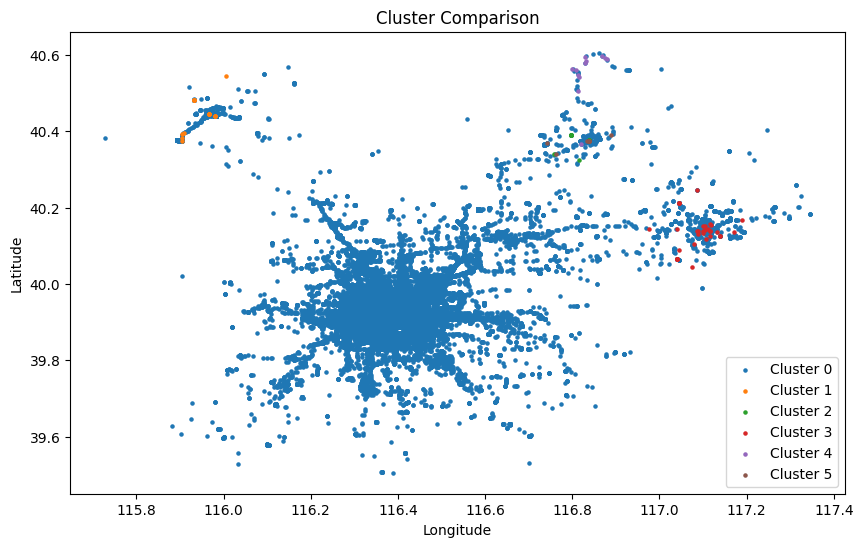

In [33]:
import matplotlib.pyplot as plt
# Visualize the clusters
plt.figure(figsize=(10, 6))
for label in [0, 1, 2, 3, 4, 5]:
    cluster_points = df_sample[df_sample['cluster_008'] == label]
    plt.scatter(cluster_points['longitude'], cluster_points['latitude'], s=5, label=f"Cluster {label}")
plt.legend()
plt.title("Cluster Comparison")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()